Model Development

In [2]:
! pip install -r ../requirements.txt

In [34]:
import sys
import os
sys.path.append('C:/Users/Sania Serrao/projects/LULCmapsGen/src')

from dataset import unzip_data, get_dataset_info,split_dataset_and_transform,create_dataloaders
from torchvision import datasets

from visualize import plot_images, plot_data_distribution,plot_results

import torch
from torchgeo.models import ResNet50_Weights
from torch.optim import SGD
from torch import nn
import torchsummary
from tqdm import tqdm

from develop_model import initialize_model,fit,evaluate
from utils import save_model,load_model



In [4]:

# Paths
zip_path = 'C:/Users/Sania Serrao/projects/LULCmapsGen/data/EuroSAT.zip'
data_dir = 'C:/Users/Sania Serrao/projects/LULCmapsGen/data/EuroSAT/2750'


unzip_data(zip_path, 'C:/Users/Sania Serrao/projects/LULCmapsGen/data/EuroSAT/')
dataset = datasets.ImageFolder(data_dir)
get_dataset_info(dataset, data_dir)
class_names=dataset.classes



Data already unzipped at C:/Users/Sania Serrao/projects/LULCmapsGen/data/EuroSAT/
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10

Displaying structure of the dataset:
2750/
    AnnualCrop/
        AnnualCrop_1.jpg
        AnnualCrop_10.jpg
    Forest/
        Forest_1.jpg
        Forest_10.jpg
    HerbaceousVegetation/
        HerbaceousVegetation_1.jpg
        HerbaceousVegetation_10.jpg
    Highway/
        Highway_1.jpg
        Highway_10.jpg
    Industrial/
        Industrial_1.jpg
        Industrial_10.jpg
    Pasture/
        Pasture_1.jpg
        Pasture_10.jpg
    PermanentCrop/
        PermanentCrop_1.jpg
        PermanentCrop_10.jpg
    Residential/
        Residential_1.jpg
        Residential_10.jpg
    River/
        River_1.jpg
        River_10.jpg
    SeaLake/
        SeaLake_1.jpg
        SeaLake_10.jpg


In [15]:
train,val,test=split_dataset_and_transform(dataset)
print('Size of Train dataset: ', len(train))
print('Size of Validation dataset: ', len(val))
print('Size of Test dataset: ', len(test))

#creating dataloaders to make the datasets iterable as well as sample batches
train_loader,val_loader,test_loader=create_dataloaders(train, val, test)

Size of Train dataset:  18900
Size of Validation dataset:  4050
Size of Test dataset:  4050


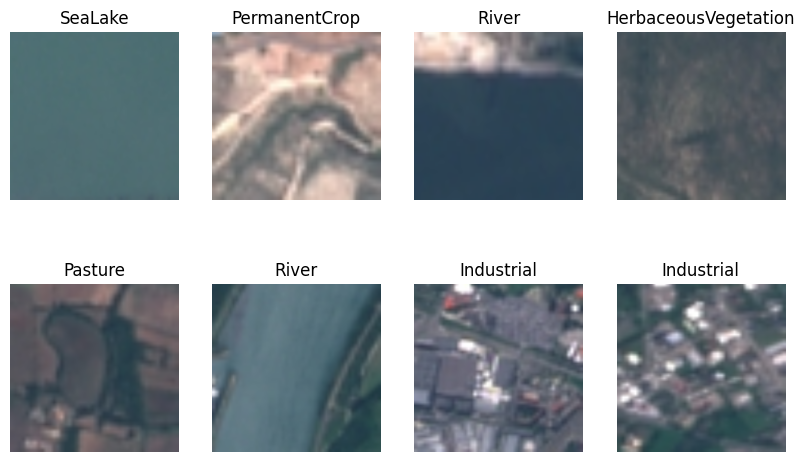

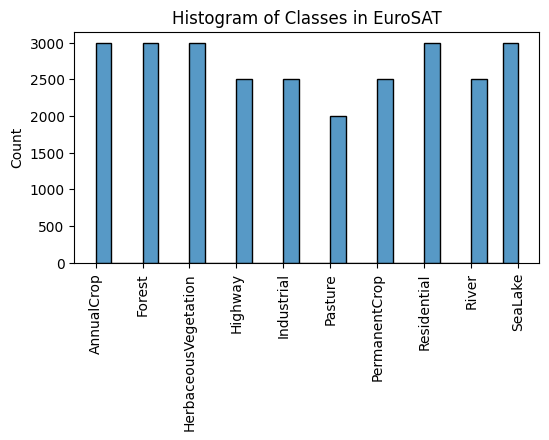

In [19]:
#plotting images
plot_images(train_loader, class_names)
plot_data_distribution(dataset)

Model Development


In [20]:

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [21]:


weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = initialize_model("resnet50", weights, num_classes=10, device=device)

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
#init hyperparameters, loss function and optimizer
n_epochs = 10
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr)

In [23]:
best_model,accuracy_history = fit(model, train_loader, val_loader, n_epochs, criterion, optimizer,device)

Epoch 1


Train Loss: 2.25; Accuracy: 39.11%


Val Loss: 2.13; Accuracy: 49.48%
Epoch 2


Train Loss: 1.94; Accuracy: 44.97%


Val Loss: 1.53; Accuracy: 54.84%
Epoch 3


Train Loss: 1.51; Accuracy: 51.70%


Val Loss: 1.13; Accuracy: 63.85%
Epoch 4


Train Loss: 1.20; Accuracy: 63.67%


Val Loss: 0.81; Accuracy: 79.16%
Epoch 5


Train Loss: 0.93; Accuracy: 72.63%


Val Loss: 0.50; Accuracy: 86.12%
Epoch 6


Train Loss: 0.74; Accuracy: 78.39%


Val Loss: 0.39; Accuracy: 89.01%
Epoch 7


Train Loss: 0.63; Accuracy: 81.57%


Val Loss: 0.30; Accuracy: 91.09%
Epoch 8


Train Loss: 0.55; Accuracy: 83.86%


Val Loss: 0.30; Accuracy: 90.96%
Epoch 9


Train Loss: 0.48; Accuracy: 85.53%


Val Loss: 0.29; Accuracy: 90.86%
Epoch 10


Train Loss: 0.44; Accuracy: 86.98%


Val Loss: 0.24; Accuracy: 93.01%


In [24]:
test_loss,test_acc = evaluate(best_model, test_loader, criterion, phase="test",device=device)
print("Test Loss: ", test_loss)
print("Test Accuracy: ",test_acc)

Test Loss: 0.24; Accuracy: 92.64%
Test Loss:  0.23957903781054932
Test Accuracy:  tensor(92.6420, device='cuda:0')


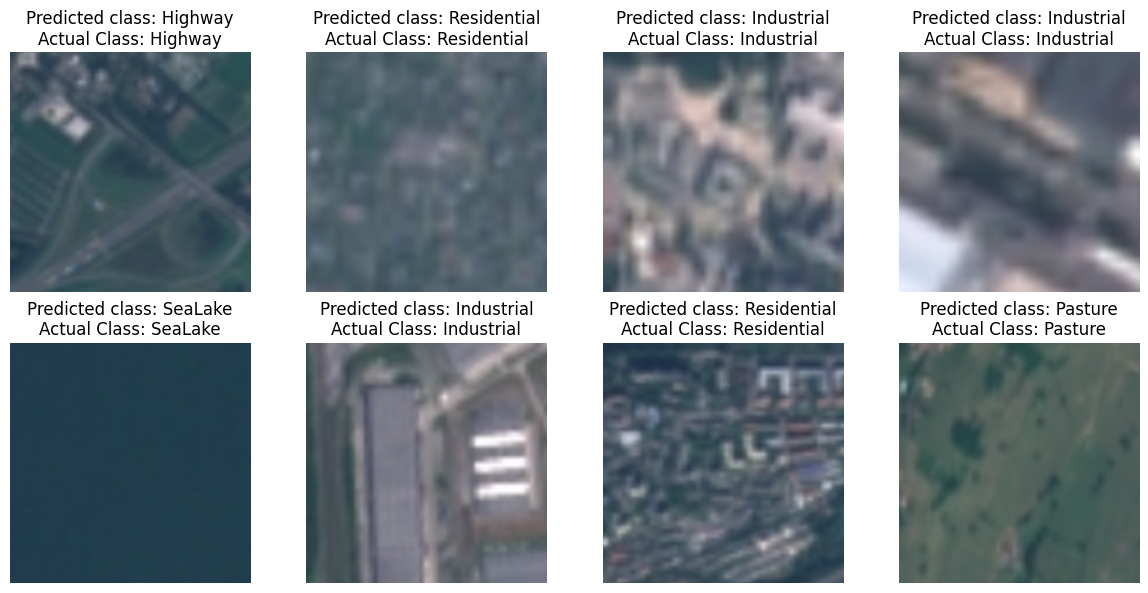

In [25]:
best_model = best_model.to(device)
plot_results(test_loader,best_model,class_names,device,)

In [27]:
model_dir = "C:/Users/Sania Serrao/projects/LULCmapsGen/models"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')

save_model(best_model, model_file)

Model successfully saved to C:/Users/Sania Serrao/projects/LULCmapsGen/models\best_model.pth.


In [28]:
model = load_model(model_file) #testing if loading works

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Sania Serrao/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:21<00:00, 4.80MB/s]
C:\Users/Sania Serrao/projects/LULCmapsGen/src\utils.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where

Model file C:/Users/Sania Serrao/projects/LULCmapsGen/models\best_model.pth successfully loaded.
